In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from riemannian_2d import *

## Flat Euclidean metric

In [3]:
"""Test flat Euclidean metric."""
x, y = symbols('x y', real=True)
g = Matrix([[1, 0], [0, 1]])
metric = Metric2D(g, (x, y))

# Curvature should be zero
K = metric.gauss_curvature()
assert K == 0

# Geodesics should be straight lines
traj = geodesic_solver(metric, (0, 0), (1, 1), (0, 5), n_steps=100)
expected_x = np.linspace(0, 5, 100)
expected_y = np.linspace(0, 5, 100)

assert np.allclose(traj['x'], expected_x, rtol=1e-2)
assert np.allclose(traj['y'], expected_y, rtol=1e-2)

print("✓ Euclidean metric test passed")

✓ Euclidean metric test passed


## Polar coordinate metric

In [4]:
"""Test polar coordinate metric."""
r, theta = symbols('r theta', real=True, positive=True)
g_polar = Matrix([[1, 0], [0, r**2]])
metric = Metric2D(g_polar, (r, theta))

# Gauss curvature should be zero (flat space in polar coords)
K = metric.gauss_curvature()
assert simplify(K) == 0

# Laplace-Beltrami
lb = metric.laplace_beltrami_symbol()
xi, eta = symbols('xi eta', real=True)
expected_principal = xi**2 + eta**2 / r**2
assert simplify(lb['principal'] - expected_principal) == 0

print("✓ Polar coordinates test passed")

✓ Polar coordinates test passed


## Metric on sphere

In [5]:
"""Test metric on sphere."""
theta, phi = symbols('theta phi', real=True)
g_sphere = Matrix([[1, 0], [0, sin(theta)**2]])
metric = Metric2D(g_sphere, (theta, phi))

# Gaussian curvature should be 1 (unit sphere)
K = metric.gauss_curvature()
# K = 1 for unit sphere
K_simplified = simplify(K)
print(f"Sphere curvature: {K_simplified}")

# Ricci scalar should be 2
R = metric.ricci_scalar()
R_simplified = simplify(R)
print(f"Ricci scalar: {R_simplified}")

print("✓ Sphere metric test passed")

Sphere curvature: 1
Ricci scalar: 2
✓ Sphere metric test passed


## Hyperbolic Geometry

In [6]:
"""
Test on the Poincaré half-plane (Hyperbolic Geometry).
Metric: g_ij = (1/y^2) * delta_ij
Expected curvature: constant -1.
"""
print("Testing Poincaré Half-Plane (Negative Curvature)...")
x, y = symbols('x y', real=True)
# y must be positive
g = Matrix([[1/y**2, 0], [0, 1/y**2]])
metric = Metric2D(g, (x, y))

# 1. Curvature test (should be -1)
K = metric.gauss_curvature()
assert simplify(K) == -1, f"Expected curvature -1, got {K}"

# 2. Geodesic test (Vertical line is a geodesic)
# Start from (0, 1) upwards (0, 1)
# Analytical solution: x(t)=0, y(t) = e^t (if default parameterization)
traj = geodesic_solver(metric, (0, 1), (0, 1), (0, 1), method='rk45')

assert np.allclose(traj['x'], 0, atol=1e-4), "Geodesic should remain on x=0"
assert traj['y'][-1] > 1, "Geodesic should move upwards"

print("✓ Poincaré test passed")

Testing Poincaré Half-Plane (Negative Curvature)...
✓ Poincaré test passed


## Metric construction from a Hamiltonian

In [7]:
"""
Test metric construction from a Hamiltonian.
Example: Free particle in polar coordinates.
H = (p_r^2 + p_theta^2/r^2) / 2
"""
print("Testing Hamiltonian construction...")
r, theta = symbols('r theta', real=True, positive=True)
pr, pt = symbols('p_r p_theta', real=True)

H = (pr**2 + pt**2 / r**2) / 2
metric = Metric2D.from_hamiltonian(H, (r, theta), (pr, pt))

g_expected = Matrix([[1, 0], [0, r**2]])

assert simplify(metric.g_matrix - g_expected) == zeros(2, 2), "Failed to reconstruct polar metric from Hamiltonian"
print("✓ Hamiltonian construction test passed")

Testing Hamiltonian construction...
✓ Hamiltonian construction test passed


## Numerical integrator comparison

In [8]:
"""
Compare numerical integrators (RK45 vs Symplectic)
and the reparameterization option.
"""
print("Testing Geodesic Integrators & Options...")
x, y = symbols('x y', real=True)
g = Matrix([[1, 0], [0, 1]]) # Flat
metric = Metric2D(g, (x, y))

p0 = (0, 0)
v0 = (1, 1) # Speed norm sqrt(2)
tspan = (0, 10)

# 1. Symplectic test (Energy conservation)
traj_sym = geodesic_solver(metric, p0, v0, tspan, method='symplectic', n_steps=100)
energy_var = np.std(traj_sym['energy'])
assert energy_var < 1e-10, f"Symplectic integrator failed to conserve energy. Var: {energy_var}"

# 2. Reparameterization test (Arc length)
traj_rk = geodesic_solver(metric, p0, v0, tspan, method='rk45', reparametrize=True)
assert 'arc_length' in traj_rk
# For a flat metric, s = v * t = sqrt(2) * 10
total_length = traj_rk['arc_length'][-1]
expected_length = np.sqrt(2) * 10
assert np.isclose(total_length, expected_length, rtol=1e-3), \
    f"Arc length calc failed. Got {total_length}, expected {expected_length}"

print("✓ Geodesic integrators test passed")

Testing Geodesic Integrators & Options...
✓ Geodesic integrators test passed


## Exponential Map and Distance functions

In [9]:
"""
Test Exponential Map and Distance functions.
On a flat metric, exp_p(v) = p + v.
"""
print("Testing Distance and Exponential Map...")
x, y = symbols('x y', real=True)
g = Matrix([[1, 0], [0, 1]])
metric = Metric2D(g, (x, y))

p = (0, 0)
v = (3, 4)
target = (3, 4)

# 1. Exponential Map test
end_point = exponential_map(metric, p, v, t=1.0)
assert np.allclose(end_point, target, atol=1e-4), f"Exp map failed. Got {end_point}"

# 2. Distance test (Shooting method)
d_shoot = distance(metric, p, target, method='shooting')
assert np.isclose(d_shoot, 5.0, rtol=1e-3), f"Shooting distance failed. Got {d_shoot}"

# 3. Distance test (Optimization method)
# Note: Optimize may be less precise without fine tuning, tolerance relaxed
d_opt = distance(metric, p, target, method='optimize')
assert np.isclose(d_opt, 5.0, rtol=5e-2), f"Optimization distance failed. Got {d_opt}"

print("✓ Distance functions test passed")

Testing Distance and Exponential Map...
✓ Distance functions test passed


## Riemannian volume and Hodge Star operator

In [10]:
"""
Test Riemannian volume and Hodge Star operator.
"""
print("Testing Hodge Star and Volume...")
x, y = symbols('x y', real=True)
# Simple but non-unit diagonal metric: g = diag(4, 9)
# det(g) = 36, sqrt(g) = 6
g = Matrix([[4, 0], [0, 9]])
metric = Metric2D(g, (x, y))

# 1. Volume test (Unit square [0,1]x[0,1])
# Volume = Integral(sqrt(g) dx dy) = 6 * 1 * 1 = 6
vol_sym = metric.riemannian_volume(((0, 1), (0, 1)), method='symbolic')
vol_num = metric.riemannian_volume(((0, 1), (0, 1)), method='numerical')

assert vol_sym == 6, f"Symbolic volume wrong. Got {vol_sym}"
assert np.isclose(vol_num, 6.0), f"Numerical volume wrong. Got {vol_num}"

# 2. Hodge Star test on 2-form (Scalar -> Scalar)
# * (f dx^dy) = f / sqrt(g)
# If f=12, result = 12 / 6 = 2
star2 = hodge_star(metric, 2)
res = star2(12)
assert simplify(res) == 2, f"Hodge star on 2-form failed. Got {res}"

print("✓ Hodge and Volume test passed")

Testing Hodge Star and Volume...
✓ Hodge and Volume test passed


## Jacobi equation

In [11]:
"""
Test Jacobi equation (geodesic deviation).
On a sphere, parallel geodesics converge (focusing).
J(t) should decrease or oscillate.
"""
print("Testing Jacobi Equation (Sphere Stability)...")
theta, phi = symbols('theta phi', real=True)
# Sphere metric (avoid poles for numerical test)
g = Matrix([[1, 0], [0, sin(theta)**2]])
metric = Metric2D(g, (theta, phi))

# Equatorial geodesic: theta=pi/2, phi varies
# Initial speed: theta_dot=0, phi_dot=1
geod = geodesic_solver(metric, (np.pi/2, 0), (0, 1), (0, 2), n_steps=200)

# Initial orthogonal perturbation (towards the north pole)
# J0 = 0, DJ0 = (v_theta=0.1, v_phi=0)
init_var = {'J0': (0, 0), 'DJ0': (0.1, 0)}

jac = jacobi_equation_solver(metric, geod, init_var, (0, 2))

# On the sphere, J(t) ~ sin(t).
# Initially J increases, but the "separation speed" DJ should decrease
# due to positive curvature R > 0.

# Check that J_x (theta deviation) does not explode exponentially (as in hyperbolic)
max_dev = np.max(np.abs(jac['J_x']))
assert max_dev < 1.0, "Jacobi field deviation too large for sphere"

print("✓ Jacobi equation test passed")

Testing Jacobi Equation (Sphere Stability)...
✓ Jacobi equation test passed


## The "Cosmic Donut" (Torus Geometry)

Courbure de Gauss (symbolique) :
cos(theta)/(cos(theta) + 3)
Génération de la carte de courbure...


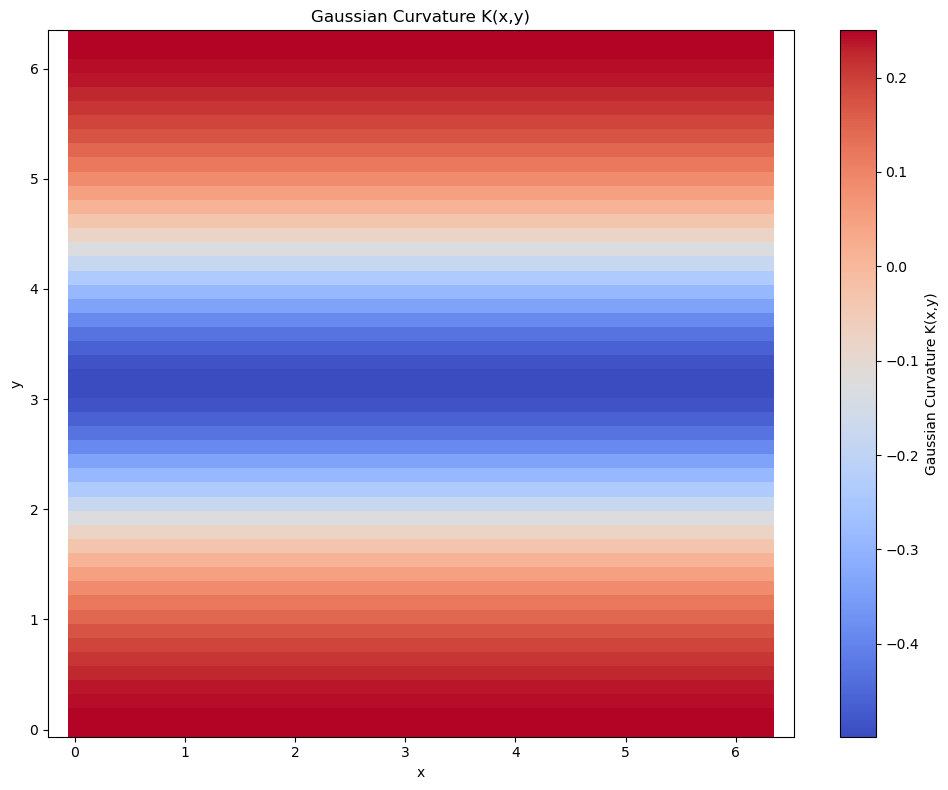

In [13]:
## The "Cosmic Donut" (Torus Geometry)
# 1. Definition of symbols and parameters
theta, phi = symbols('theta phi', real=True)
R, r = 3, 1  # Major radius, minor radius
# 2. Torus Metric induced in R3
# ds^2 = (R + r*cos(theta))^2 dphi^2 + r^2 dtheta^2
g_torus = Matrix([
    [(R + r*cos(theta))**2, 0],
    [0, r**2]
])
# 3. Instantiation
metric_torus = Metric2D(g_torus, (phi, theta))
print("Gaussian curvature (symbolic):")
print(metric_torus.gauss_curvature())
# 4. Visualization of the curvature
# Phi ranges from 0 to 2pi, Theta ranges from 0 to 2pi
print("Generating curvature map...")
visualize_curvature(
    metric_torus,
    x_range=(0, 2*np.pi),
    y_range=(0, 2*np.pi),
    quantity='gauss',
    cmap='coolwarm'  # Red = positive, Blue = negative
)


## Escher's Universe (The Poincaré Half-Plane)

Simulating hyperbolic geodesics...


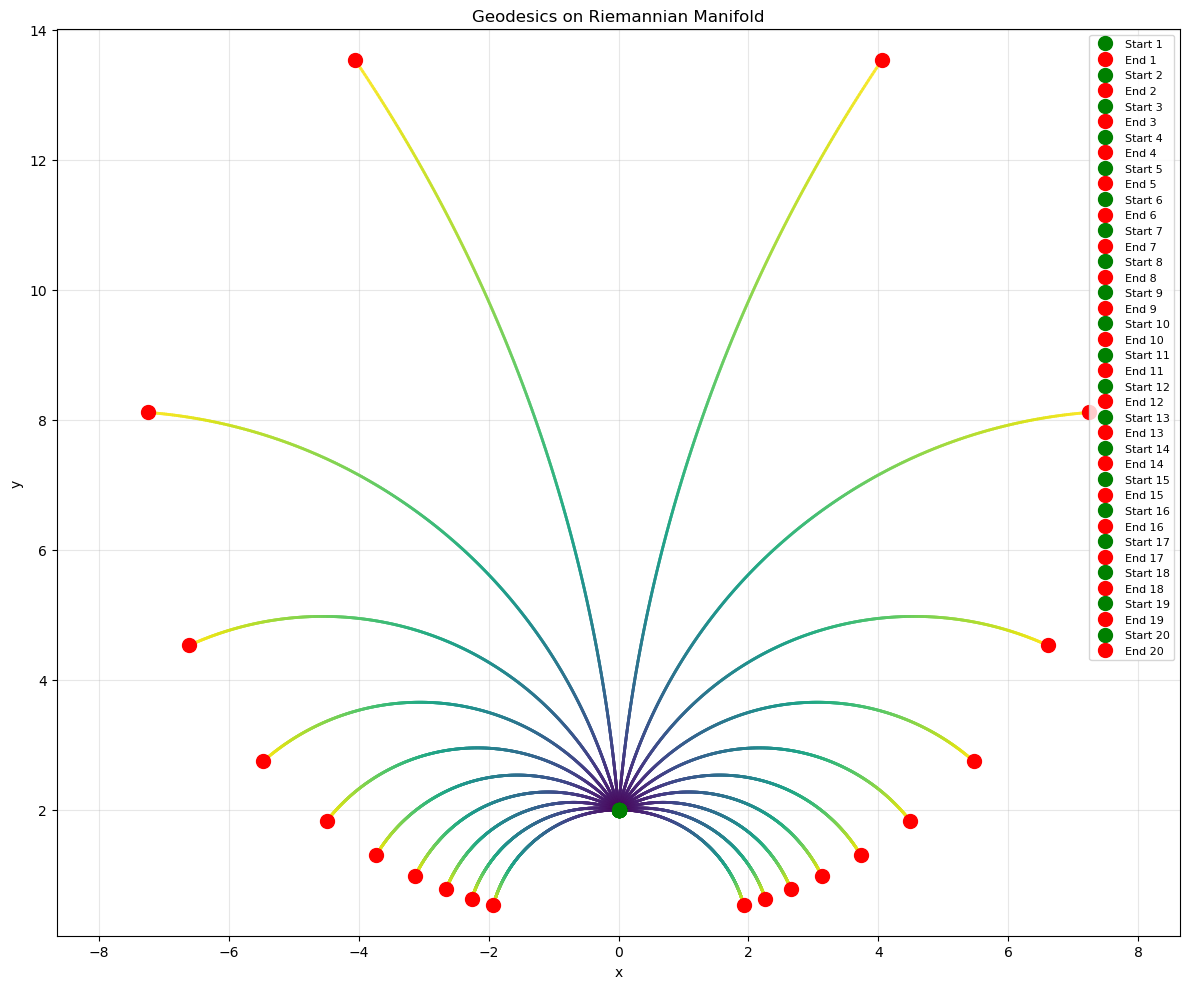

In [17]:
# 1. Hyperbolic metric
x, y = symbols('x y', real=True)
# g_ij = (1/y^2) * delta_ij
g_poincare = Matrix([
    [1/y**2, 0],
    [0, 1/y**2]
])
metric_hyp = Metric2D(g_poincare, (x, y))

# 2. Initial conditions: A "spray" of geodesics starting from a point
start_point = (0, 2)
angles = np.linspace(0, np.pi, 20)
ics = []
# Particles are launched in all directions downward/sideways
for angle in angles:
    vx = np.cos(angle)
    vy = np.sin(angle)
    ics.append((start_point, (vx, vy)))

# 3. Visualization
print("Simulating hyperbolic geodesics...")
visualize_geodesics(
    metric_hyp,
    ics,
    tspan=(0, 4),
    plot_curvature=False,  # Curvature is constant (-1), no need for heatmap
    x_range=(-4, 4),
    y_range=(0.1, 5)
)


## Orbits around a Black Hole (Flamm's Paraboloid)

Extended simulation of relativistic orbits...


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


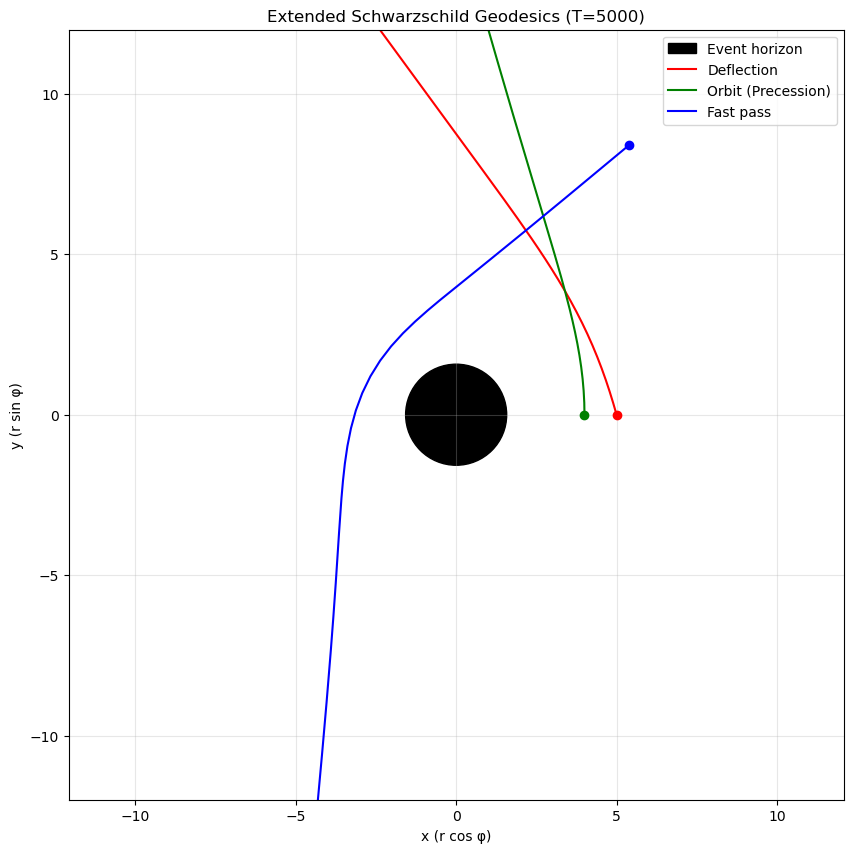

In [5]:
# 1. Metric definition
r, phi = symbols('r phi', real=True)
rs = 1.5  # Schwarzschild radius
g_sch = Matrix([
    [1/(1 - rs/r), 0],
    [0, r**2]
])
metric_bh = Metric2D(g_sch, (r, phi))

# 2. Initial conditions (unchanged)
# Slightly modified ICs for better visualization of precession:
ics = [
    # (r0, phi0), (vr, vphi)
    ((5.0, 0), (-0.3, 0.22)),   # Deflection (Red)
    ((4.0, 0), (0, 0.14)),      # Near-circular orbit (Green)
    ((10.0, 1.0), (-1.5, 0.05)) # Fast pass (Blue)
]
print("Extended simulation of relativistic orbits...")

# 3. Manual Solving and Visualization (with extended time)
plt.figure(figsize=(10, 10))
ax = plt.gca()

# Draw the event horizon (Black circle r=1)
rs_plot = 1.05 * rs
event_horizon = plt.Circle((0, 0), rs_plot, color='black', label='Event horizon')
ax.add_artist(event_horizon)

# Solve and plot each trajectory
colors = ['red', 'green', 'blue']
labels = ['Deflection', 'Orbit (Precession)', 'Fast pass']

# --- NEW INTEGRATION PARAMETERS ---
T_MAX = 5000    # Longer duration (tspan=(0, 400))
STEPS = 15000  # More points for precision
# ----------------------------------------
for i, (p0, v0) in enumerate(ics):
    # Solve with new parameters
    traj = geodesic_solver(metric_bh, p0, v0, tspan=(0, T_MAX), n_steps=STEPS, method='symplectic')

    # Polar -> Cartesian conversion
    r_vals = traj['x']
    phi_vals = traj['y']
    x_plot = r_vals * np.cos(phi_vals)
    y_plot = r_vals * np.sin(phi_vals)

    plt.plot(x_plot, y_plot, color=colors[i], label=labels[i], linewidth=1.5)

    # Fix here: Use named arguments `marker` and `color`
    # Mark the start (circle 'o')
    plt.plot(x_plot[0], y_plot[0], marker='o', color=colors[i], markersize=6)
    # Mark the end (square 's')
    plt.plot(x_plot[-1], y_plot[-1], marker='s', color=colors[i], markersize=6)

# Formatting
plt.axis('equal')
limit = 12
plt.xlim(-limit, limit)
plt.ylim(-limit, limit)
plt.grid(True, alpha=0.3)
plt.legend()
plt.title(f"Extended Schwarzschild Geodesics (T={T_MAX})")
plt.xlabel("x (r cos φ)")
plt.ylabel("y (r sin φ)")
plt.show()


## The Gaussian Hill (Lens & Chaos)

Simulating diffusion by Gaussian curvature...


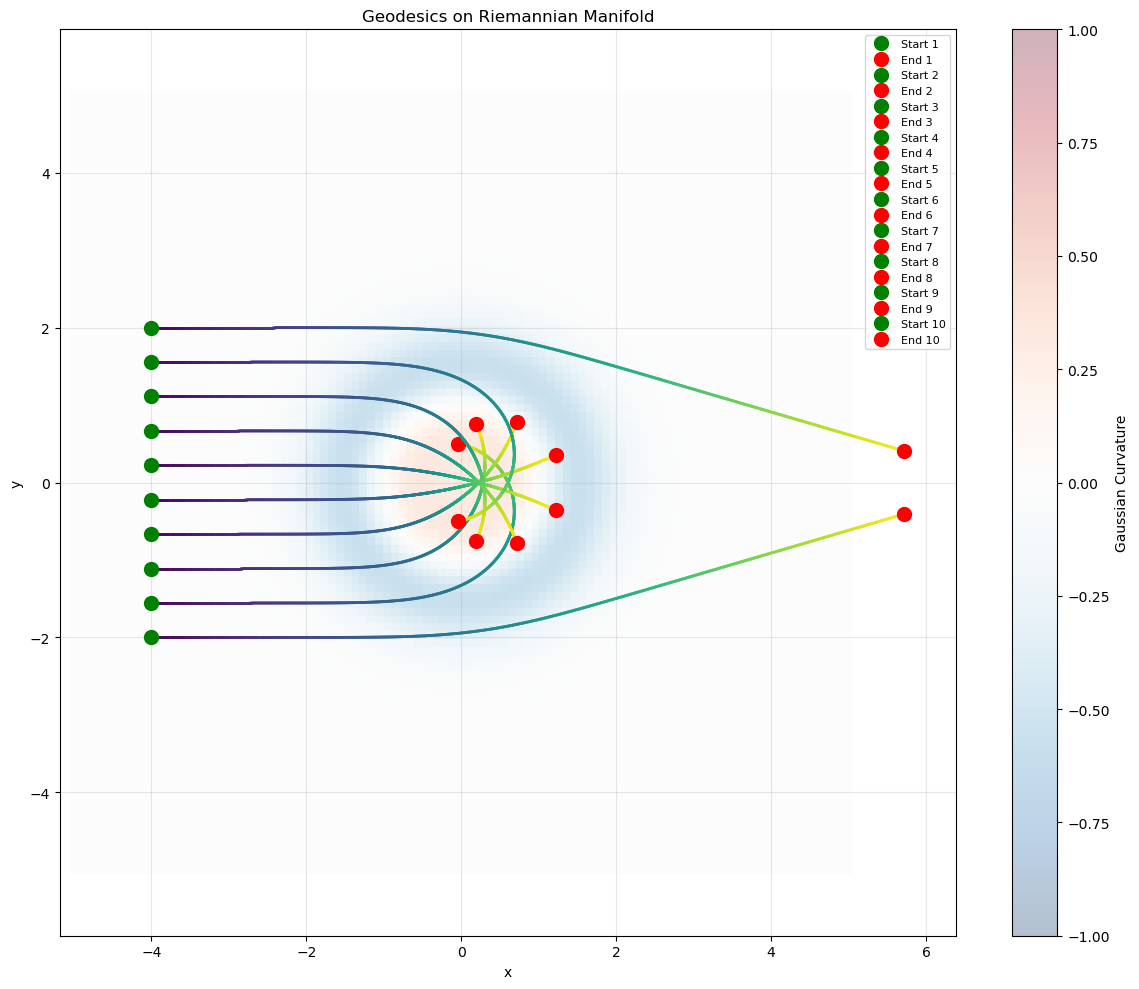

In [18]:
# 1. A flat plane with a Gaussian bump at the center
x, y = symbols('x y', real=True)
A = 3.0  # Amplitude of the deformation
sigma = 1.0
bump = A * exp(-(x**2 + y**2) / sigma)
# Conformal metric: g_ij = e^(bump) * delta_ij
# This amounts to locally stretching space
g_bump = Matrix([
    [exp(bump), 0],
    [0, exp(bump)]
])
metric_bump = Metric2D(g_bump, (x, y))
# 2. Bundle of parallel particles
y_starts = np.linspace(-2, 2, 10)
ics = []
for y0 in y_starts:
    # Start from x=-4, move to the right (vx=1)
    # Note: With a conformal metric, the "physical" speed depends on position
    ics.append(((-4, y0), (1.0, 0)))
print("Simulating diffusion by Gaussian curvature...")
visualize_geodesics(
    metric_bump,
    ics,
    tspan=(0, 10),
    x_range=(-5, 5),
    y_range=(-5, 5),
    plot_curvature=True # We want to see the bump in the background!
)
